# 1. Copy and prepare raw data

In [1]:
import google.datalab.storage as storage
import os

# See all the items we can fine
shared_bucket = storage.Bucket('carvana')
for obj in shared_bucket.objects():
  if obj.key.find('/') < 0:
    print(obj.key)

train_hq.zip
train_masks.zip


In [2]:
# Create some helper function for copying and unzipping
def maybe_copy(root, gs_location, zip_file):
  if os.path.exists(os.path.join(root, zip_file)):
    print("%s already copied.." % zip_file)
    return
  gs_loc = os.path.join(gs_location, zip_file)
  !gsutil cp $gs_loc $root
  
def maybe_unzip(root, zip_file):
  if os.path.exists(os.path.join(root, zip_file.split('.')[0])):
    print("%s already unzipped.." % zip_file)
    return
  zip_loc = os.path.join(root, zip_file)
  !unzip -qq $zip_loc -d $root

In [3]:
gs_location = 'gs://carvana'
root = '/content'

for obj in shared_bucket.objects():
  if obj.key.find('/') < 0:
    if obj.key.split('.')[1] == "zip":
      maybe_copy(root, gs_location, obj.key)
      maybe_unzip(root, obj.key)

train_hq.zip already copied..
train_hq.zip already unzipped..
train_masks.zip already copied..
train_masks.zip already unzipped..


# 2. View the images

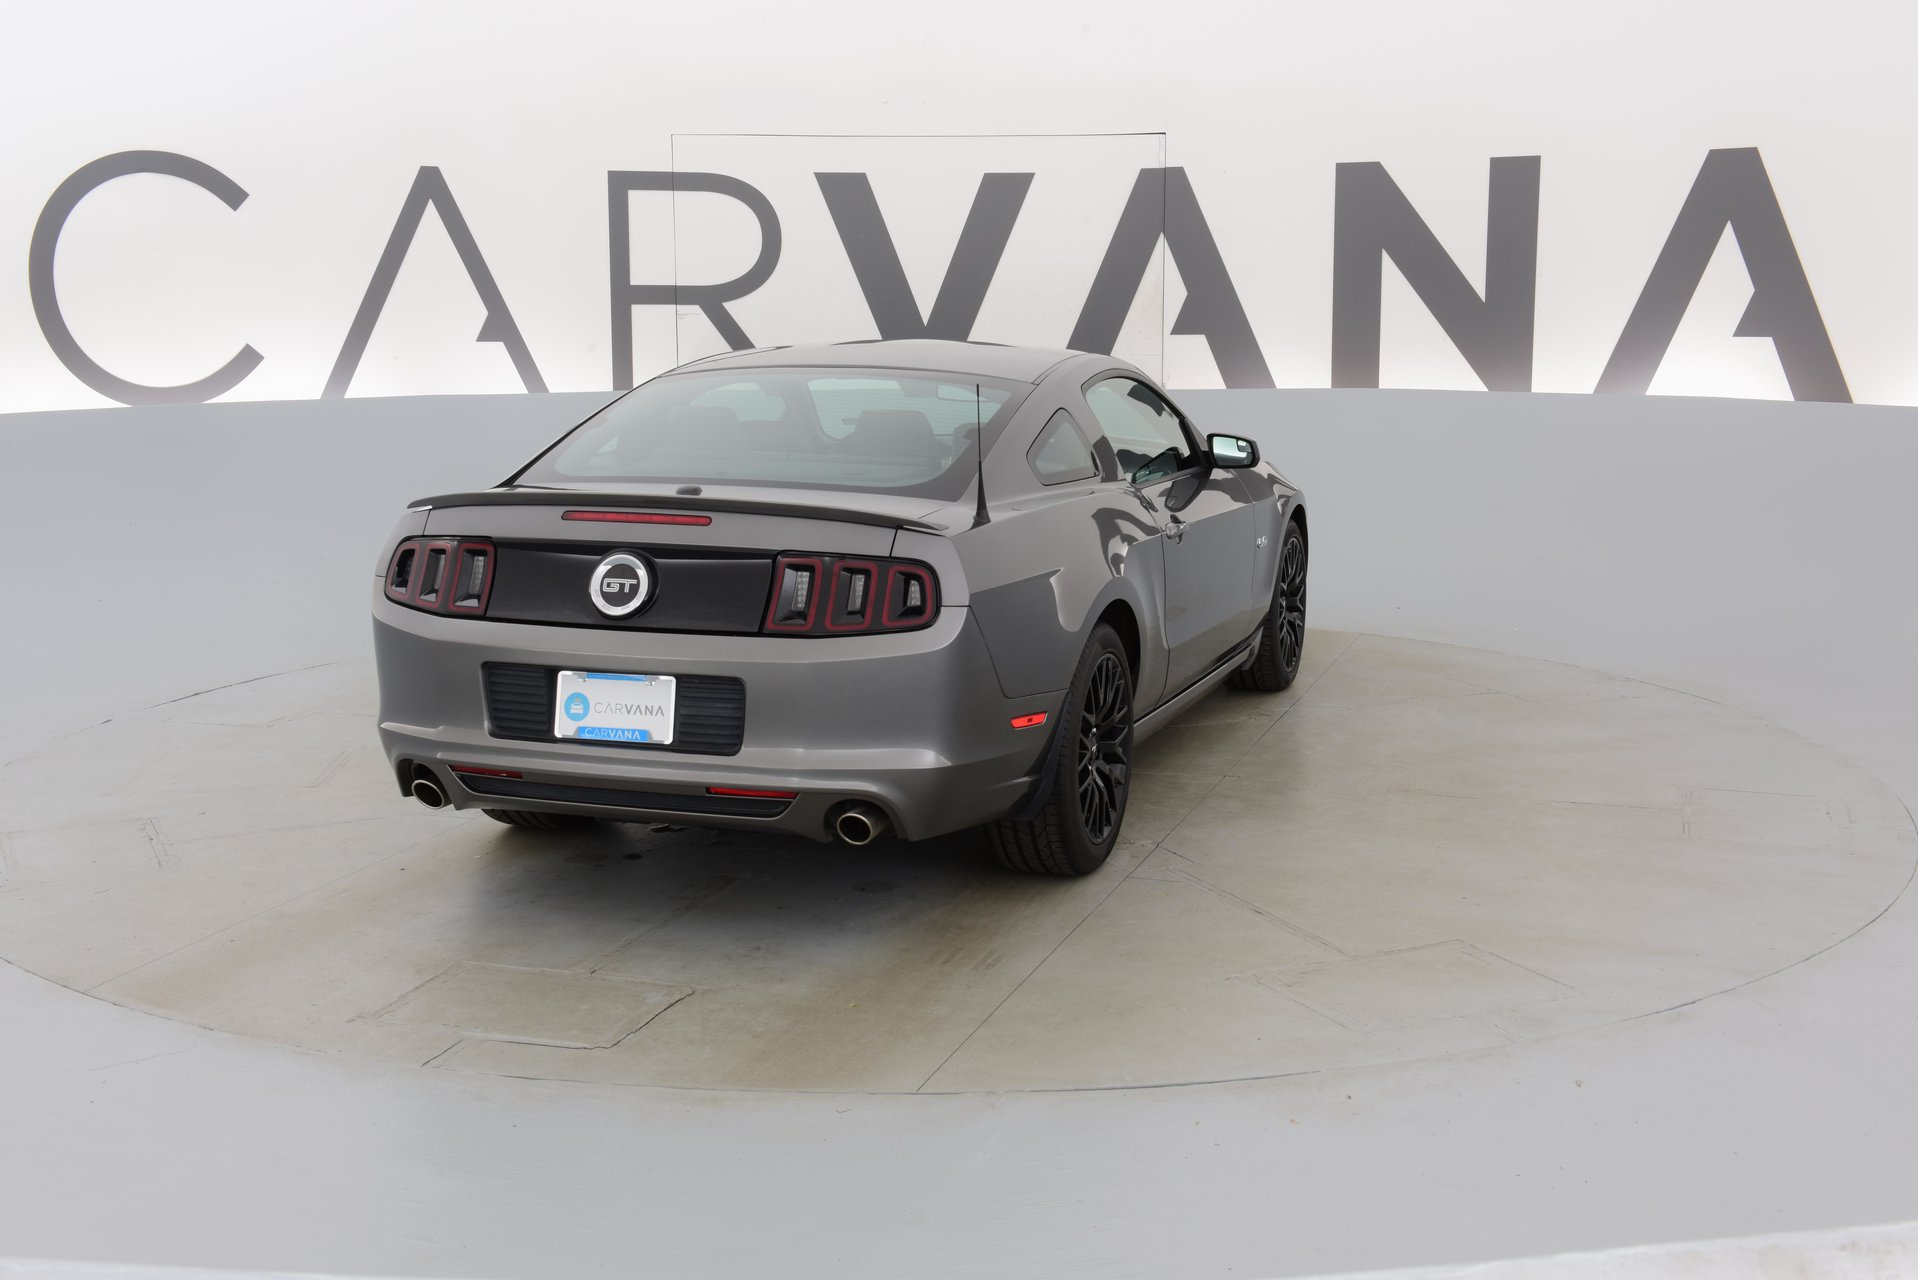

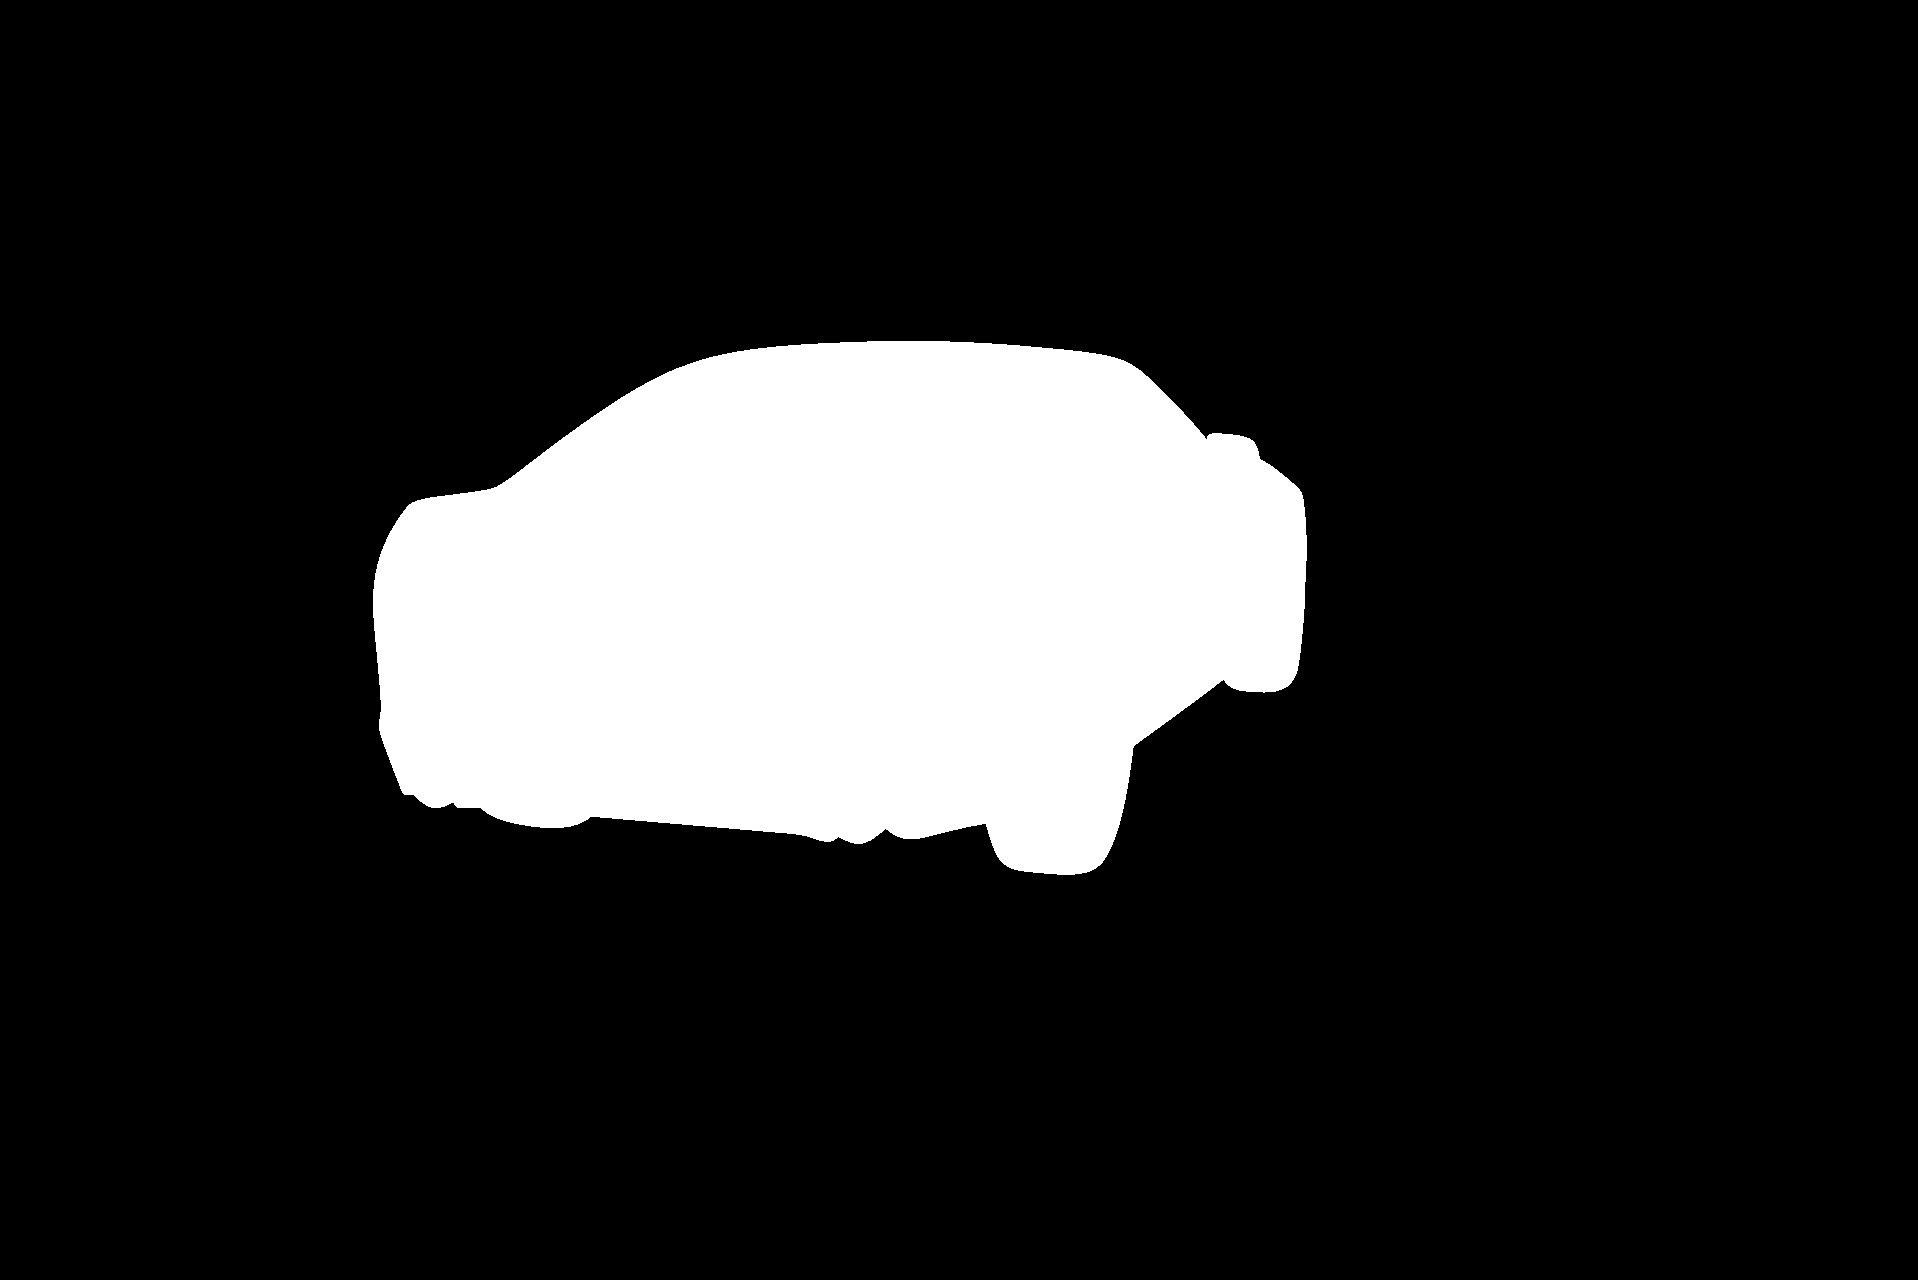

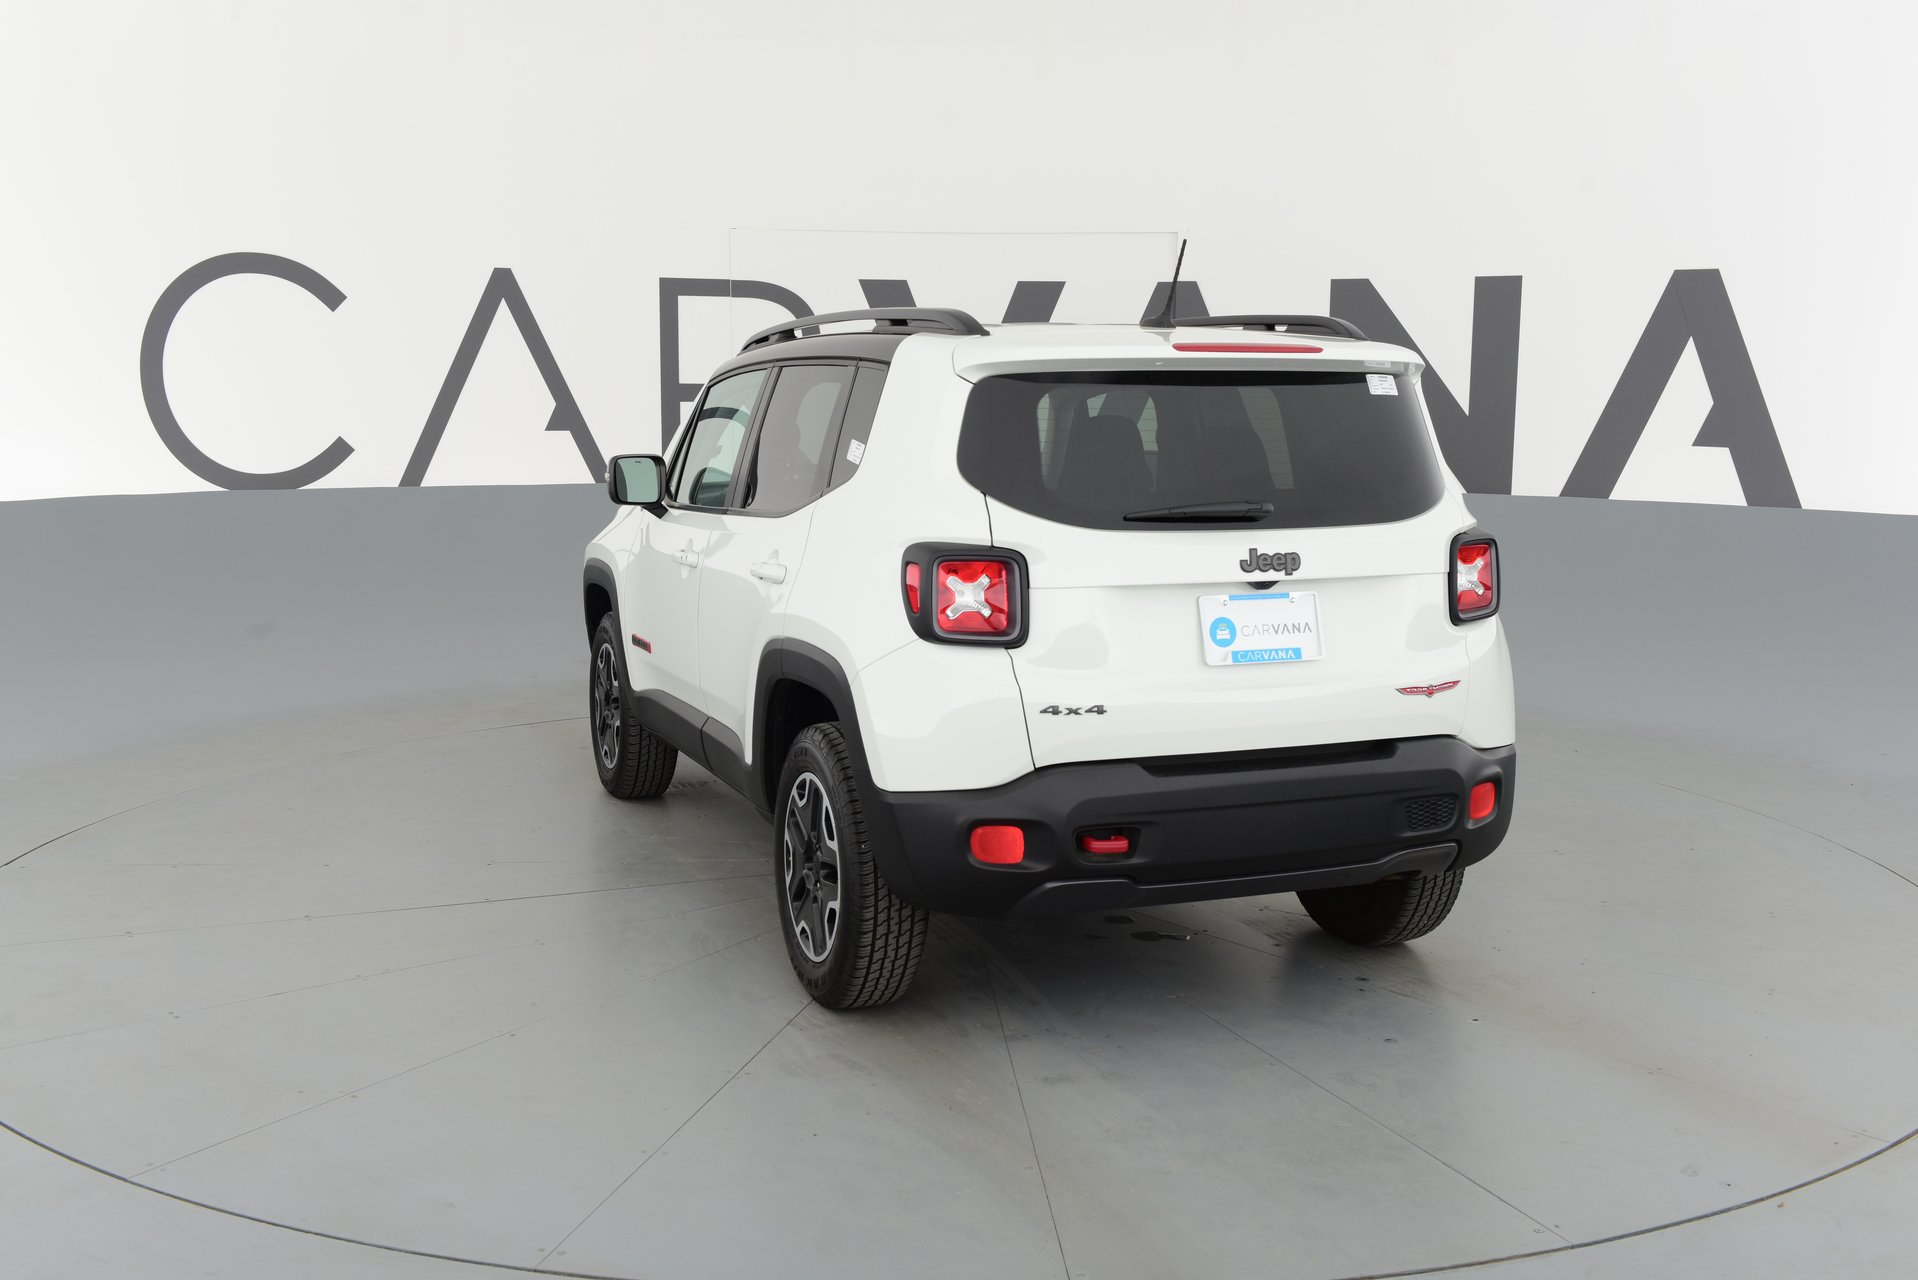

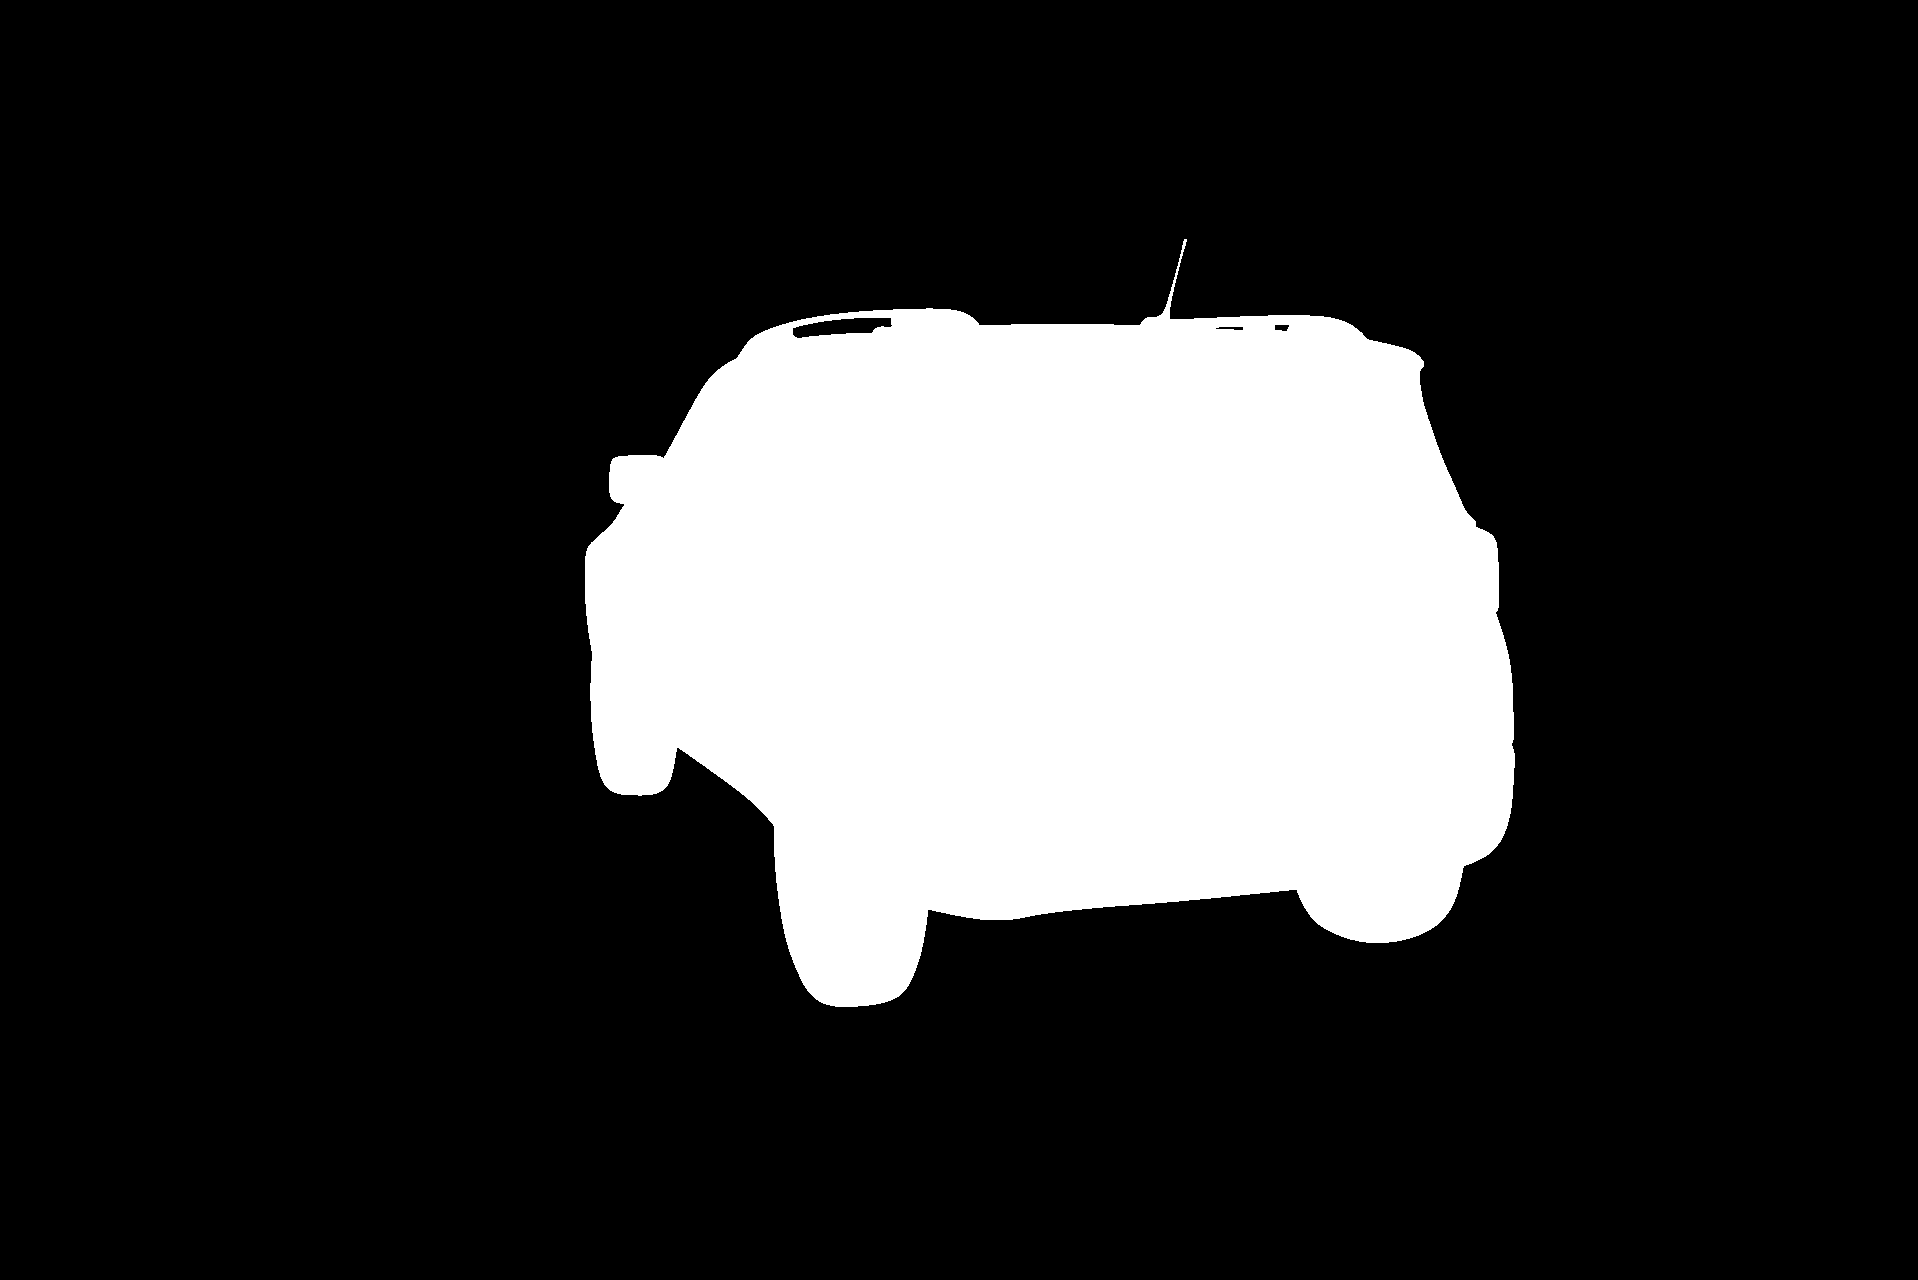

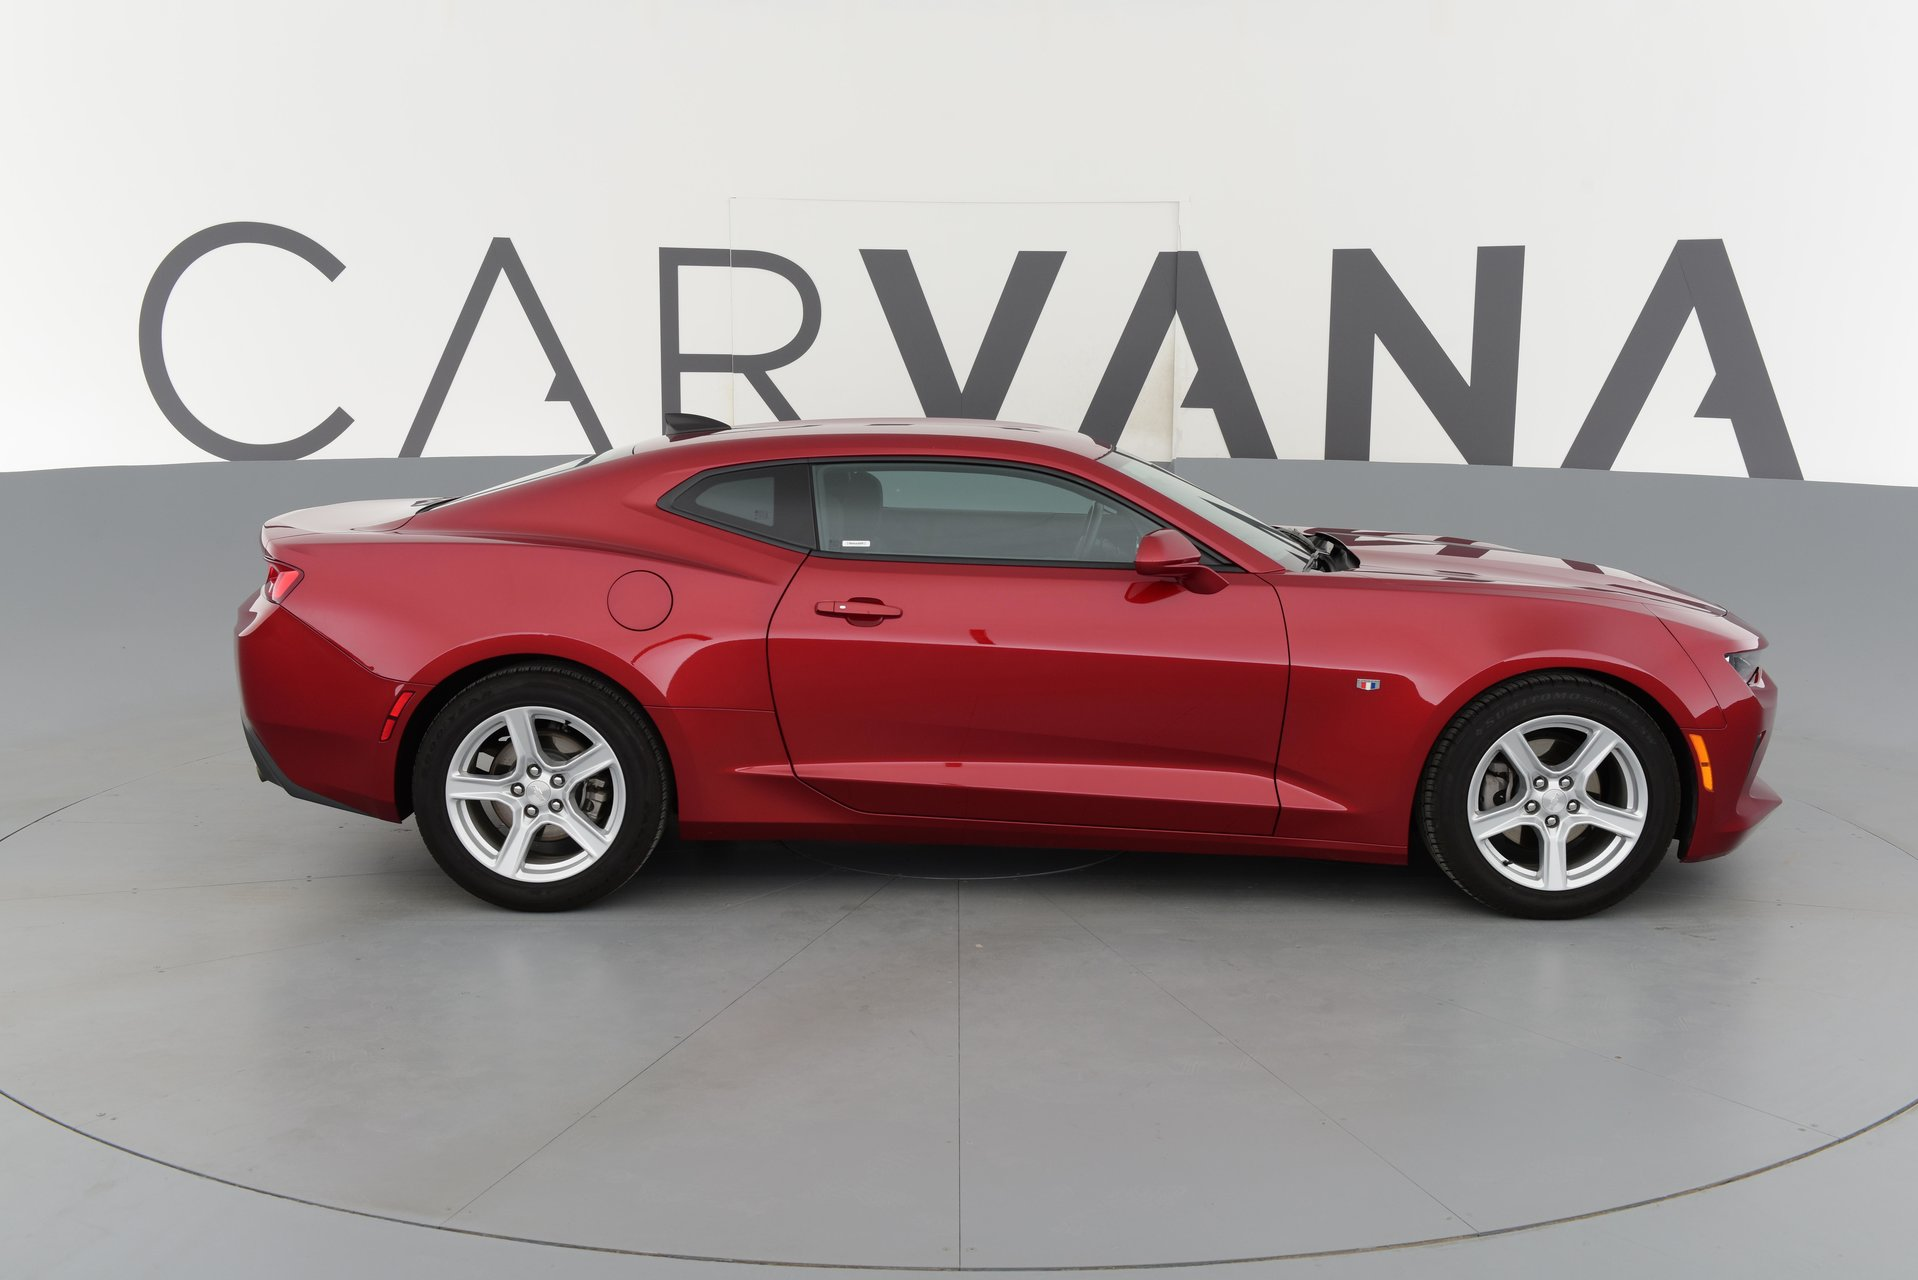

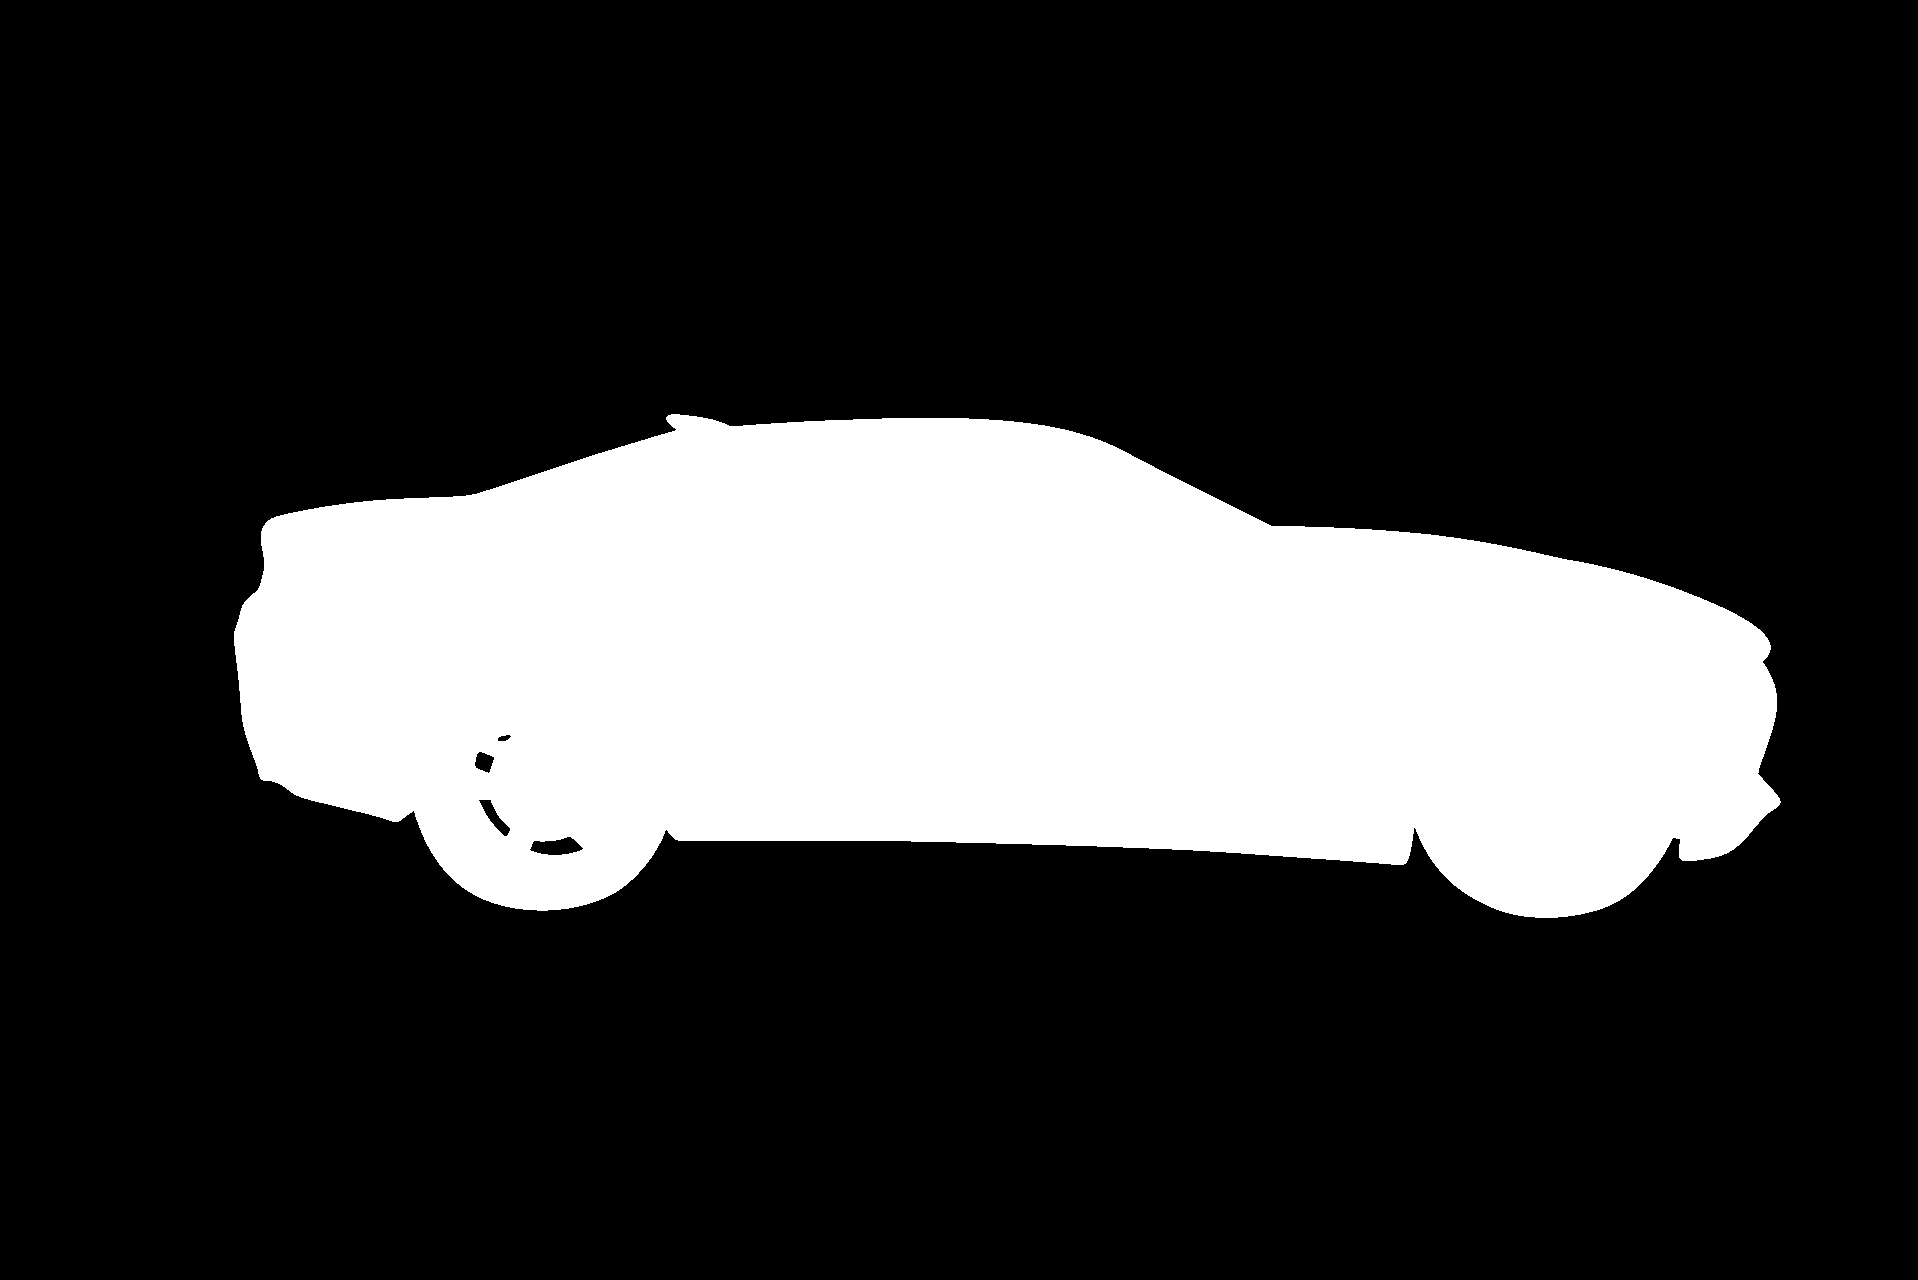

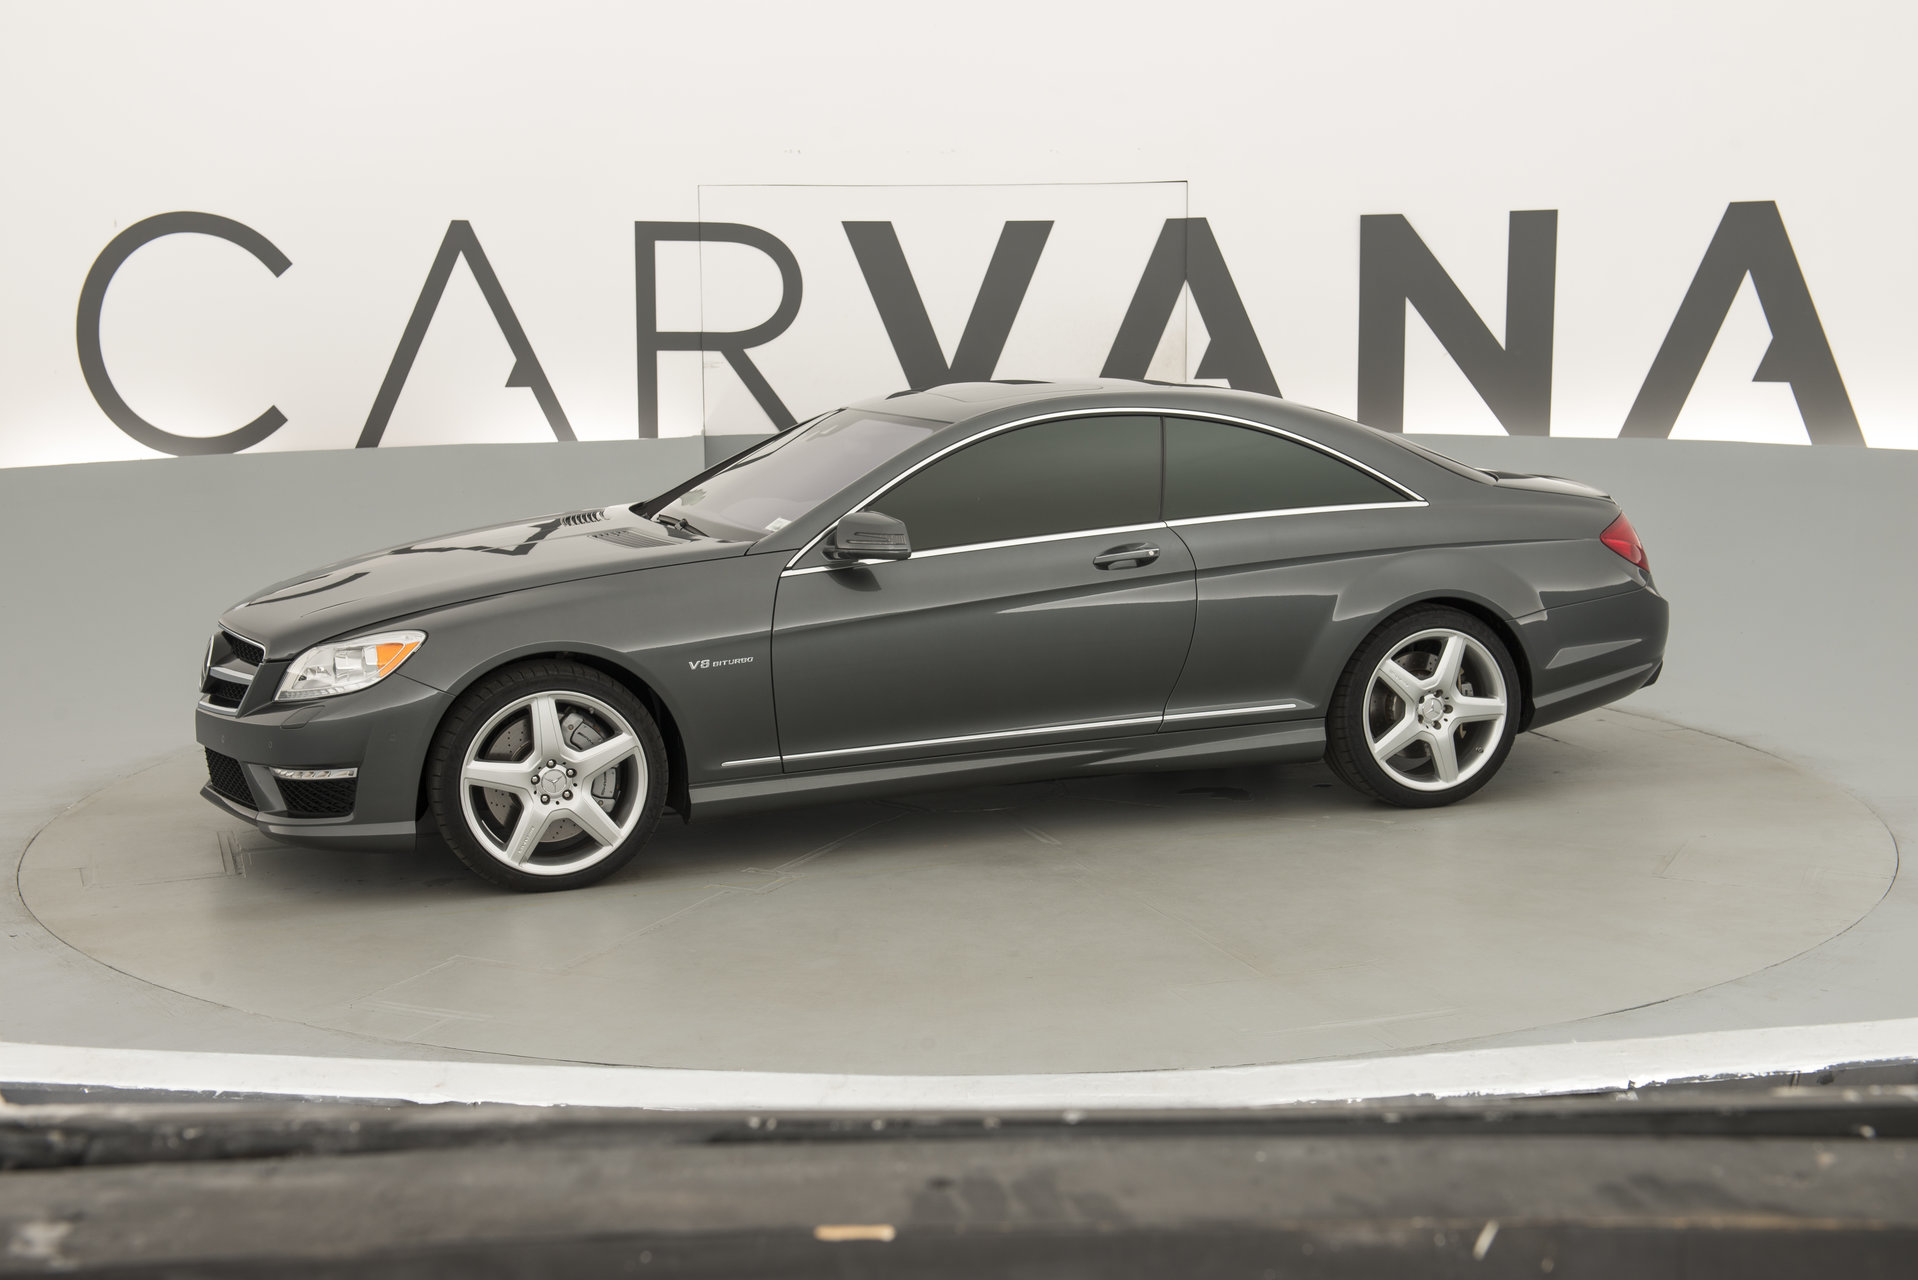

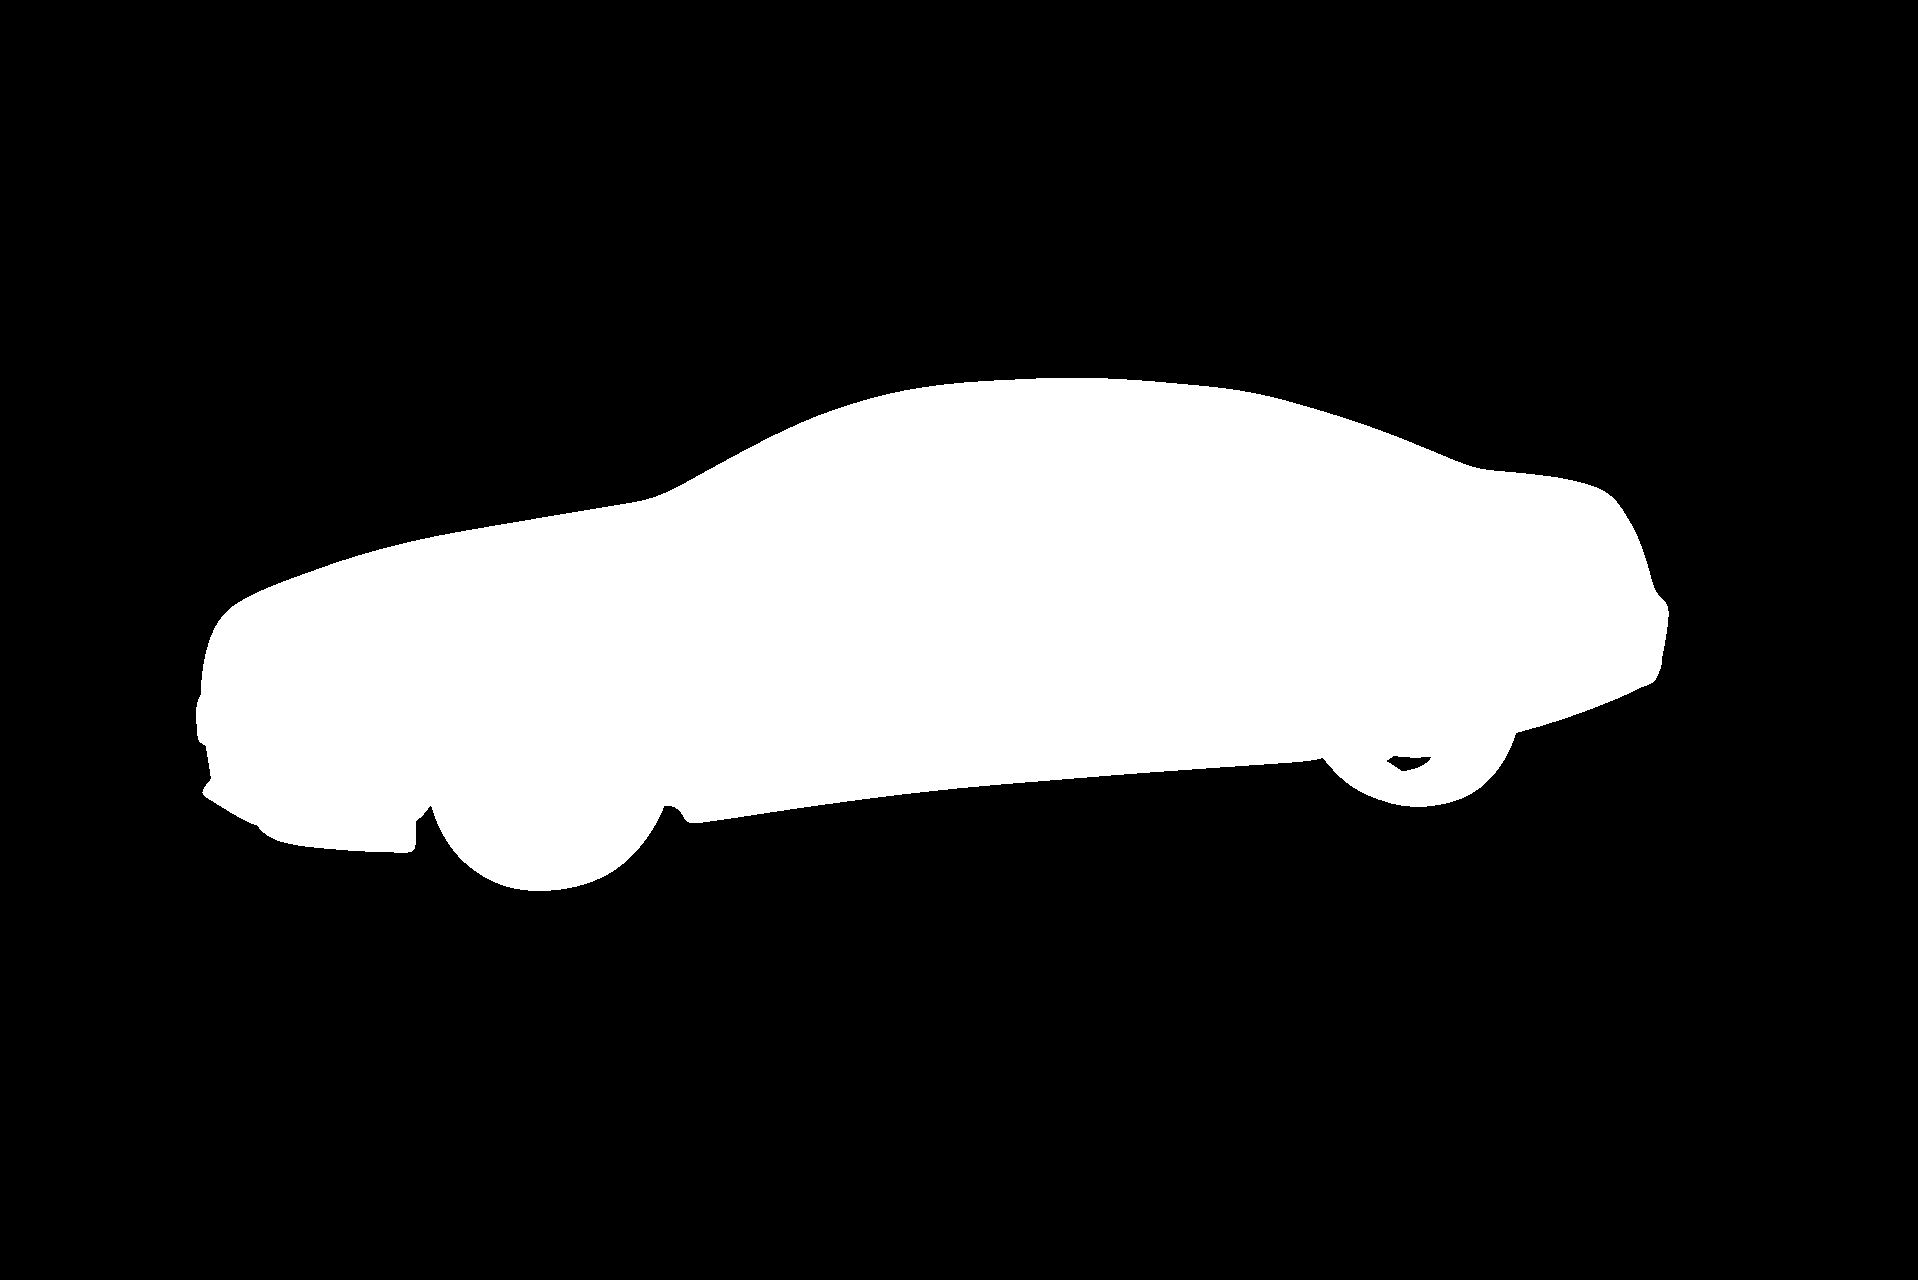

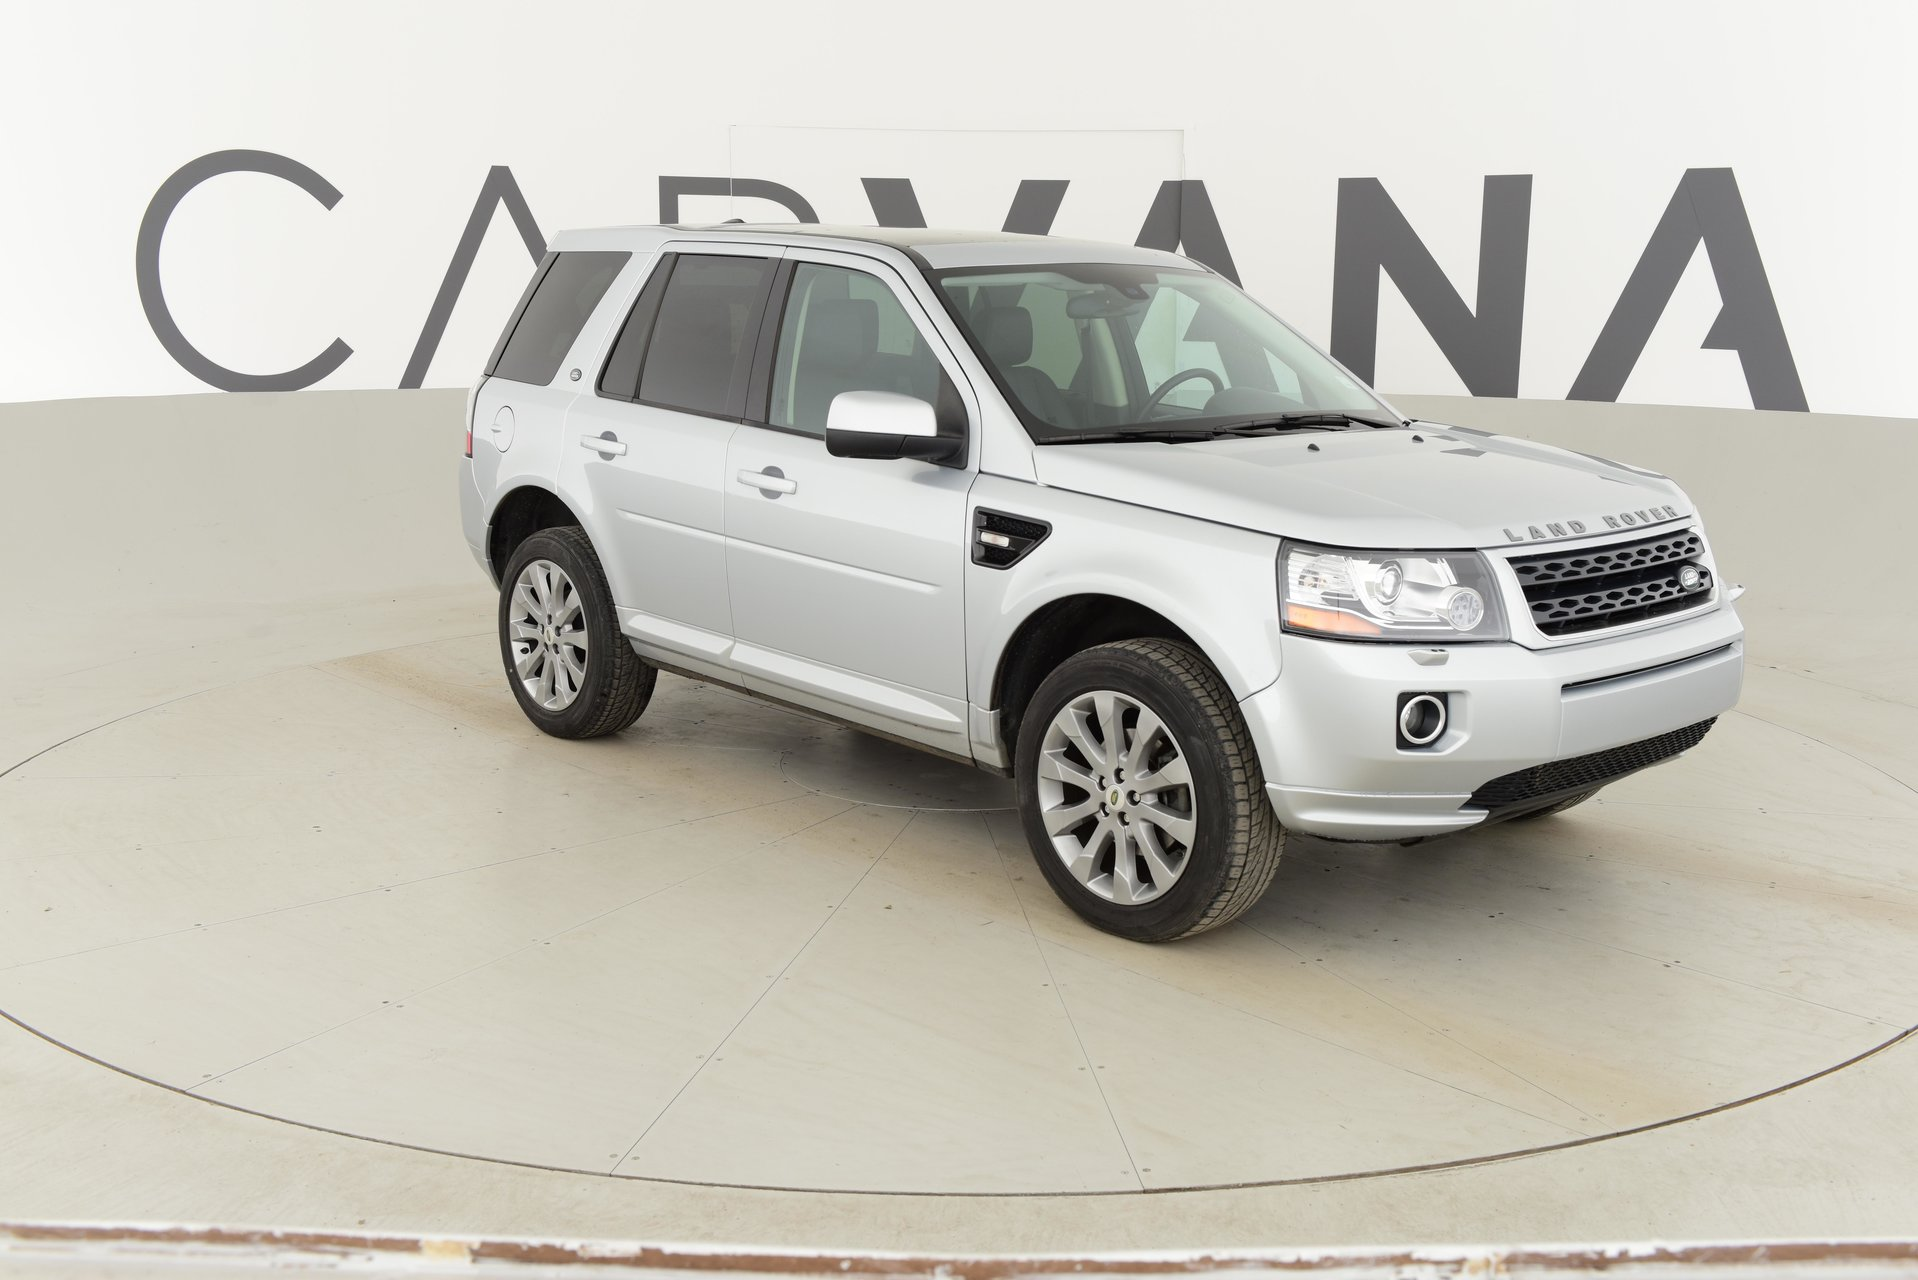

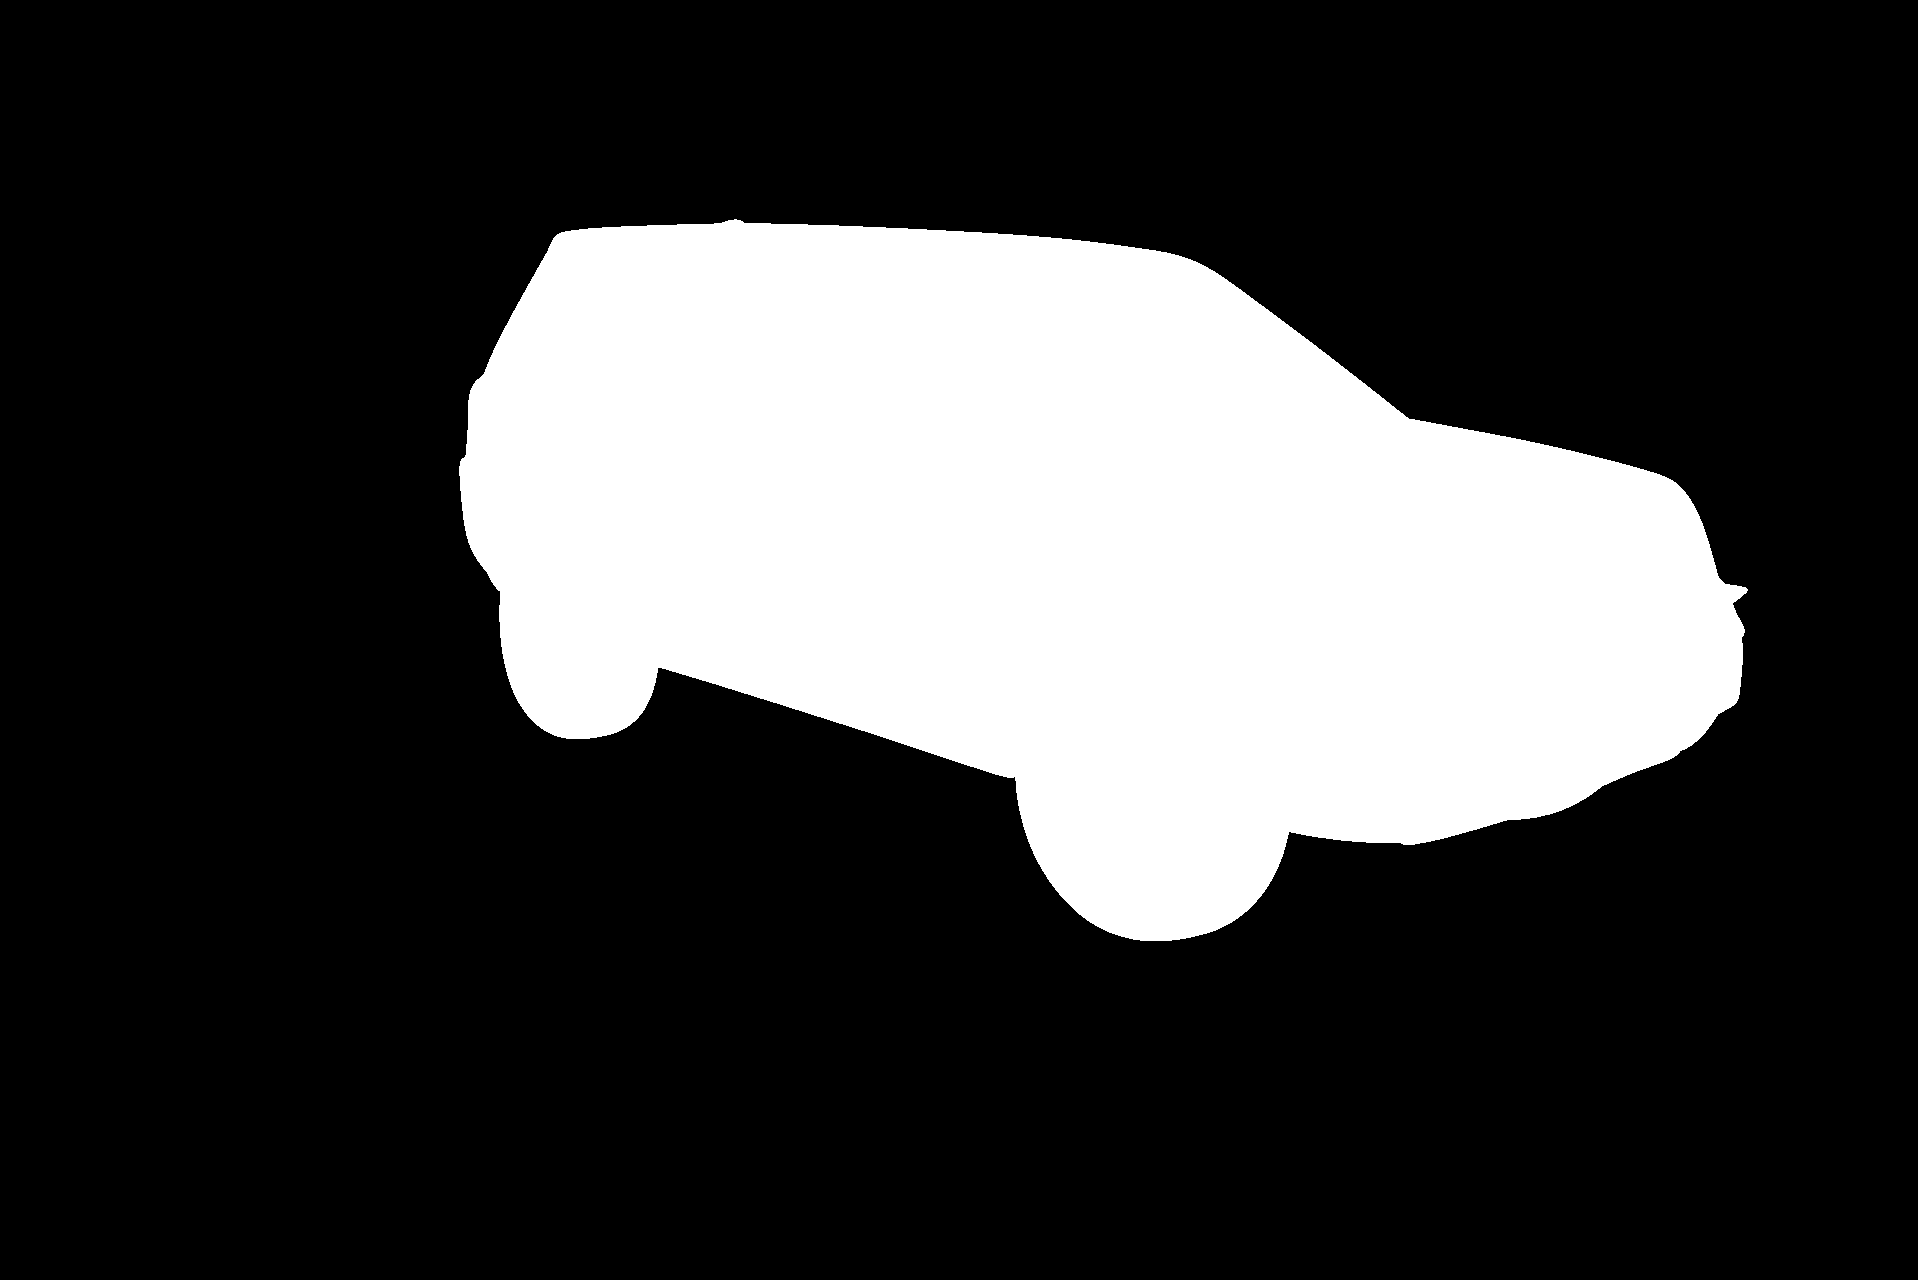

In [4]:
from IPython.display import Image 
from IPython.display import display
from random import shuffle

def yield_images(feature_root, mask_root, N):
  file_names = os.listdir(feature_root)
  shuffle(file_names)
  pairs = []
  for i, f in enumerate(file_names):
    pairs.append(os.path.abspath(os.path.join(feature_root, f)))
    pairs.append(os.path.abspath(os.path.join(mask_root, f.replace('.jpg', '_mask.gif'))))
    if i == N-1:
      break
  yield pairs

# Show N images
img_gen = yield_images(os.path.join(root, 'train_hq'), os.path.join(root, 'train_masks'), 5)
def display_these(list_of_images):
  img = []
  for i, image in enumerate(list_of_images):
    if i % 2:
      with open(image,'rb') as f:
        img.append(Image(data=f.read(), format='png', width=400))
        continue
    img.append(Image(image, width=400))

  display(*img)
  
# Get random images
display_these(next(img_gen))


# 3. Create TFRecords for the data

In [5]:
from src.tfrecord.parsers import ImgImgParser

feature_img_folder = os.path.join(root, 'train_hq')
label_img_folder = os.path.join(root, 'train_hq')
split_ratio = [0.8, 0.1, 0.1]
my_parser = ImgImgParser(feature_img_folder, label_img_folder, split_ratio)

# Create records
my_parser.create_records('/content/tfrecords', shards=10)

3
2
4070
